<a href="https://colab.research.google.com/github/Golden028/Machine_Learning/blob/main/JS15_TG11_2341720216_GOLDEN_CHRISTIAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "/content/drive/MyDrive/ML/images/training"
test_dir  = "/content/drive/MyDrive/ML/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Number of training samples: {len(train_img)}")
print(f"Number of testing samples: {len(test_img)}")

Number of training samples: 240
Number of testing samples: 160


In [5]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

In [6]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

In [7]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

In [8]:
# validation
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

In [9]:
# format so as to be compatible with TensorFlow/Keras.
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [10]:
# model with three layers (Input, Hidden Layers with ReLU, and an Output Layer with Sigmoid).
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)

input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# data for 20 epochs.
# Train the model
history = model.fit( X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.6851 - loss: 1.4192 - val_accuracy: 0.9167 - val_loss: 0.5913
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9568 - loss: 0.2259 - val_accuracy: 0.9583 - val_loss: 0.1097
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 2.2661e-04 - val_accuracy: 0.9583 - val_loss: 0.1332
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9950 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 5.2652e-04 - val_accuracy: 0.9583 - val_loss: 0.1812
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 1.7218e-04 - val_accuracy: 0.9583 - val_loss: 0.7139
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.8442e-05 - val_accuracy: 0.9583 - val_loss: 0.9992
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 8.1772e-06 - val_accuracy: 0.93

In [12]:
# Assess the model's performance on the
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9105 - loss: 1.3195


In [13]:
# confusion matrix
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)

y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        80
           1       0.84      0.95      0.89        80

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.88       160
weighted avg       0.89      0.88      0.88       160



[[65 15]
 [ 4 76]]


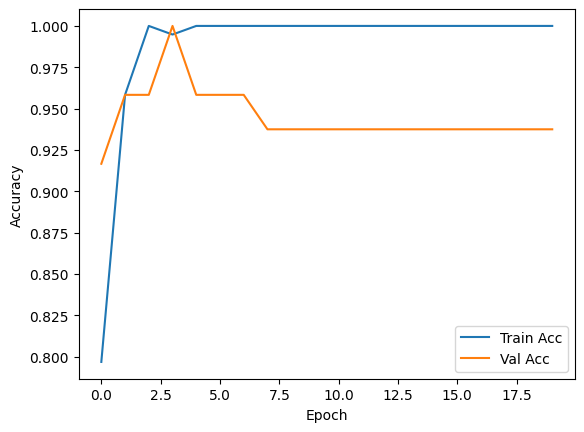

In [14]:
print(confusion_matrix(y_test, y_pred))
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# format for deployment use.
# Save the trained model

import pickle
# 1. Save Model
# Using the .keras format (recommended by Keras)
model.save('day_night_model.h5')

print("✅ Model successfully saved as: day_night_model.h5")
# 2. Save Scaler
with open('scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)

✅ Model successfully saved as: day_night_model.h5


In [18]:
# Pastikan file ada di runtime Colab
!ls -lh

# Jika file ada, gunakan cara download:
from google.colab import files
files.download('day_night_model.h5')
files.download('scaler.pkl')


total 52M
-rw-r--r-- 1 root root  51M Dec  6 14:58 day_night_model.h5
drwx------ 5 root root 4.0K Dec  6 14:51 drive
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 812K Dec  6 14:58 scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("System Loaded Successfully")
except Exception as e:
    print(f"Error loading system: {e}")

def preprocess_image(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Predict</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]

        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Result: {label}</h2><center><a href='/'>Back</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=7860)


System Loaded Successfully
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:7860
 * Running on http://172.28.0.12:7860
INFO:werkzeug:Press CTRL+C to quit
